In [9]:
import os
import os.path
import random
import gc
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [10]:
import warnings 
warnings.filterwarnings('ignore')

In [11]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [12]:
sns.set()

In [13]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [14]:
DATA_DIR = '../input/open-problems-multimodal'
%ls $DATA_DIR -lh

total 27G
-rw-r--r-- 1 nobody nogroup 2.3G Sep  7 21:12 evaluation_ids.csv
-rw-r--r-- 1 nobody nogroup 9.4M Sep  7 21:10 metadata.csv
-rw-r--r-- 1 nobody nogroup 230K Sep  7 21:10 metadata_cite_day_2_donor_27678.csv
-rw-r--r-- 1 nobody nogroup 805M Sep  7 21:11 sample_submission.csv
-rw-r--r-- 1 nobody nogroup 1.6G Sep  7 21:12 test_cite_inputs.h5
-rw-r--r-- 1 nobody nogroup 294M Sep  7 21:10 test_cite_inputs_day_2_donor_27678.h5
-rw-r--r-- 1 nobody nogroup 6.1G Sep  7 21:13 test_multi_inputs.h5
-rw-r--r-- 1 nobody nogroup 2.4G Sep  7 21:12 train_cite_inputs.h5
-rw-r--r-- 1 nobody nogroup  37M Sep  7 21:10 train_cite_targets.h5
-rw-r--r-- 1 nobody nogroup  11G Sep  7 21:13 train_multi_inputs.h5
-rw-r--r-- 1 nobody nogroup 3.0G Sep  7 21:12 train_multi_targets.h5


## Read Data

In [15]:
%%time
train_inp = pd.read_hdf(f'{DATA_DIR}/train_cite_inputs.h5')
train_inp_cols = train_inp.columns

CPU times: user 49.8 s, sys: 5.46 s, total: 55.2 s
Wall time: 1min 14s


In [16]:
%%time
test_inp = pd.read_hdf(f'{DATA_DIR}/test_cite_inputs.h5')

CPU times: user 29.5 s, sys: 3.4 s, total: 32.9 s
Wall time: 46.1 s


In [17]:
%%time
train_tar = pd.read_hdf(f'{DATA_DIR}/train_cite_targets.h5')
train_tar_cols = train_tar.columns

CPU times: user 220 ms, sys: 58.7 ms, total: 279 ms
Wall time: 841 ms


## Data Preprocessing

Find columns with all zeroes

In [18]:
%%time
zero_cols = []
for idx, col in enumerate(train_inp_cols, 0):
    if idx % 1000 == 0:
        print(idx)
    if len(train_inp[col].unique()) == 1 or len(test_inp[col].unique()) == 1:
        zero_cols.append(col)
print('Number of columns with zero values only (Train or Test):', 
      len(zero_cols))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
Number of columns with zero values only (Train or Test): 1194
CPU times: user 42.5 s, sys: 94.4 ms, total: 42.6 s
Wall time: 42.6 s


In [19]:
%%time
train_inp = train_inp.drop(zero_cols, axis=1)
train_inp_cols = train_inp.columns
test_inp = test_inp.drop(zero_cols, axis=1)
train_inp.shape, test_inp.shape

CPU times: user 1.51 s, sys: 2.55 s, total: 4.06 s
Wall time: 4.03 s


((70988, 20856), (48663, 20856))

In [ ]:
# %%time
# np.min(train_inp.min().unique()), np.max(train_inp.max().unique())

In [20]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [21]:
sc = StandardScaler()
train_inp = sc.fit_transform(train_inp)
test_inp = sc.transform(test_inp)

In [22]:
del sc
gc.collect()

46

In [23]:
%mkdir ../tmp

mkdir: cannot create directory ‘../tmp’: File exists


In [24]:
dump_pickle(test_inp, '../tmp/test_inp')
del test_inp
gc.collect()

46

In [25]:
train_tar = train_tar.values

## Modeling

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

In [27]:
# torch.manual_seed(42)
# torch.backends.cudnn.deterministic = True

In [28]:
%%time
train_inp = torch.from_numpy(train_inp)
train_tar = torch.from_numpy(train_tar)

CPU times: user 32 µs, sys: 4 µs, total: 36 µs
Wall time: 39.8 µs


In [29]:
full_ds = TensorDataset(train_inp, train_tar)
train_sz = 56800
val_sz = len(full_ds) - train_sz
train_ds, val_ds = random_split(full_ds, 
                                [train_sz, val_sz],
                                generator=torch.Generator().manual_seed(42))

In [30]:
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [72]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
        self.linear1 = nn.Linear(20856, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.linear3 = nn.Linear(128, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.linear4 = nn.Linear(128, 140)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x

In [32]:
# preds = net(x)
# vpreds = preds - torch.mean(preds)
# vy = y - torch.mean(y)
# loss = torch.sum(vpreds * vy) / \
#        (torch.sqrt(torch.sum(vpreds ** 2)) *
#         torch.sqrt(torch.sum(vy ** 2)))
# loss

In [73]:
def train_model(train_loader, model, optimizer):
    
    model.train()
    sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(train_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        loss = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        total += batch
        sum_loss += batch * loss
    
    train_loss = sum_loss/total
    return train_loss

In [74]:
def model_eval(model, val_loader):
    model.eval()
    sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        loss = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        
        total += batch
        sum_loss += batch * loss
        
    val_loss = sum_loss/total
    return val_loss

In [95]:
net = Net()
learning_rate = 0.00001
optimizer = optim.Adam(net.parameters(),
                       lr=learning_rate)

In [96]:
%%time
epochs = 90
train_corrs = []
val_corrs = []

for i in range(epochs):
    print('epoch', i)
    train_corr = -(train_model(train_loader, net, optimizer))
    train_corrs.append(float(train_corr.detach().numpy()))
    print('train corr:', train_corr)
    val_corr = -(model_eval(net, val_loader))
    val_corrs.append(float(val_corr.detach().numpy()))
    print('val corr:', val_corr)
    print()

epoch 0
train corr: tensor(0.0505, grad_fn=<NegBackward0>)
val corr: tensor(0.1265, grad_fn=<NegBackward0>)

epoch 1
train corr: tensor(0.1896, grad_fn=<NegBackward0>)
val corr: tensor(0.2398, grad_fn=<NegBackward0>)

epoch 2
train corr: tensor(0.2952, grad_fn=<NegBackward0>)
val corr: tensor(0.3376, grad_fn=<NegBackward0>)

epoch 3
train corr: tensor(0.3902, grad_fn=<NegBackward0>)
val corr: tensor(0.4244, grad_fn=<NegBackward0>)

epoch 4
train corr: tensor(0.4766, grad_fn=<NegBackward0>)
val corr: tensor(0.5050, grad_fn=<NegBackward0>)

epoch 5
train corr: tensor(0.5533, grad_fn=<NegBackward0>)
val corr: tensor(0.5769, grad_fn=<NegBackward0>)

epoch 6
train corr: tensor(0.6191, grad_fn=<NegBackward0>)
val corr: tensor(0.6353, grad_fn=<NegBackward0>)

epoch 7
train corr: tensor(0.6732, grad_fn=<NegBackward0>)
val corr: tensor(0.6832, grad_fn=<NegBackward0>)

epoch 8
train corr: tensor(0.7158, grad_fn=<NegBackward0>)
val corr: tensor(0.7192, grad_fn=<NegBackward0>)

epoch 9
train corr:

(0.0, 1.0)

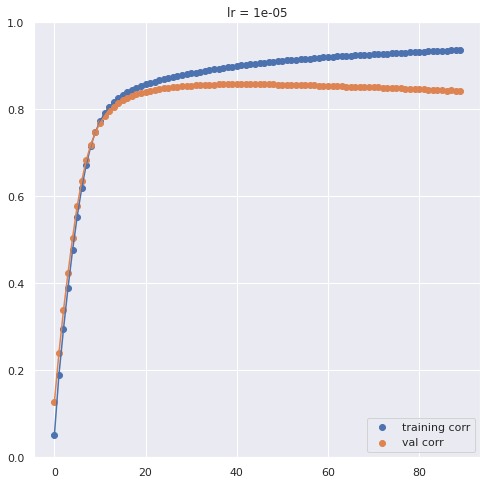

In [97]:
figsize(8, 8)
plt.scatter(list(range(epochs)), train_corrs, label='training corr')
plt.plot(list(range(epochs)), train_corrs)
plt.scatter(list(range(epochs)), val_corrs, label='val corr')
plt.plot(list(range(epochs)), val_corrs)
plt.legend(loc='lower right')
plt.title(f'lr = {learning_rate}')
plt.ylim(0, 1)

In [ ]:
# train_inp[:5]

In [ ]:
# with torch.no_grad():
#     net.eval()
#     train_tar_preds = net(train_inp[0]).detach().numpy()

In [ ]:
# np.corrcoef(train_tar_preds, train_tar[0])

In [ ]:
del train_inp, train_tar, full_ds
gc.collect()

## Prediction

In [ ]:
%%time
test_inp = load_pickle('../tmp/test_inp')
test_inp = torch.from_numpy(test_inp)

In [ ]:
with torch.no_grad():
    net.eval()
    test_tar_preds = net(test_inp).detach().numpy()

In [ ]:
del test_inp
gc.collect()

## Creating Submission

In [ ]:
DATA_DIR = '../input/msci-h5-sparse-transform'
%ls $DATA_DIR -lh

In [ ]:
test_tar_cols = np.load(f'{DATA_DIR}/train_cite_targets_idx.npz',
                        allow_pickle=True)['columns']
test_tar_idx = np.load(f'{DATA_DIR}/test_cite_inputs_idx.npz',
                       allow_pickle=True)['index']
test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

In [ ]:
%%time
print('Start Eval...')
eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

In [ ]:
%%time
sub = pd.Series(name='target',
                index=pd.MultiIndex.from_frame(eval_ids), 
                dtype=np.float32)
sub

In [ ]:
cell_id_dict = {cell_id: idx 
                for idx, cell_id in enumerate(test_tar_idx, 0)}
gene_id_dict = {gene_id: idx 
                for idx, gene_id in enumerate(test_tar_cols, 0)}

In [ ]:
eid_cid_idx = eval_ids['cell_id']\
              .apply(lambda x: cell_id_dict.get(x, -1))
eid_gid_idx = eval_ids['gene_id']\
              .apply(lambda x: gene_id_dict.get(x, -1))
valid_cite_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [ ]:
%%time
sub.iloc[valid_cite_rows] = test_tar_preds\
                             [eid_cid_idx[valid_cite_rows].to_numpy(),
                              eid_gid_idx[valid_cite_rows].to_numpy()]

In [ ]:
del eval_ids, test_tar_idx, test_tar_cols
del eid_cid_idx, eid_gid_idx, valid_cite_rows
gc.collect()

In [ ]:
sub = pd.DataFrame(sub).fillna(0).reset_index()
# sub.drop(['cell_id', 'gene_id'], axis=1)\
#    .to_csv('cite_sub.csv', index=False)
sub.head()